# PyTroch之迁移学习
实际中，基本没有人会从零开始(随机初始化)训练一个完整的卷积神经网络，因为相对于网络，很难得到一个足够大的数据集(如果网络很深，需要足够大的数据集作为依靠)。通常的做法是在一个很大的数据集上进行预训练得到卷积网络ConvNet，然后将这个ConVNet的参数作为目标任务的初始化参数或者固定这些参数。即，是否选择开启fine-tune。

## 迁移学习的两个主要场景
- 微调**ConvNet**：使用预训练的网络（如在ImageNet 1000 上训练而来的网络）来初始化自己的的网路，而不是随机初始化。其他的训练步骤不变。
- 将**ConvNet**看成固定的特征提取器：首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机初始化层，只有这个新的层会被训练（只有这层参数会在反向传播时更新）。

## 迁移学习步骤
要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。

### 导入相关包

In [4]:
# Author: Zander StriveZs

from __future__ import print_function,division

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # 该模块提供了一些根据epoch训练来调整学习速率的方法

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings

warnings.filterwarnings('ignore')

plt.ion() # 交互模式

### 加载数据
我们要解决的问题是训练一个模型来分类蚂蚁和蜜蜂，数据集中：蚂蚁和蜜蜂各有约120张训练图片、每个类各有75张验证图片。  
从零开始在如此小的数据及上进行训练通常是很难泛化的。由于我们使用迁移学习，模型的泛化能力会相当的好。该数据集是ImageNet的一个非常小的子集。  
下载地址：[clickhere](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [34]:
# 训练集数据扩充和归一化
# 在验证集上仅需要归一化

# 数据处理
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(), # 随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # 归一化
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256), # resize为256
        transforms.CenterCrop(224), # 中心裁剪
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # 归一化
    ]),
}

# 数据集位置
data_path = 'dataset/hymenoptera_data'

# 读取数据
image_datasets = {x : datasets.ImageFolder(os.path.join(data_path,x),data_transform[x]) for x in ['train', 'val']}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']}
data_size = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_name = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
print(image_datasets['train'])
print(class_name)
print(data_size)
print(next(iter(dataloaders['train'])))

Dataset ImageFolder
    Number of datapoints: 244
    Root location: dataset/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['ants', 'bees']
{'train': 244, 'val': 153}
[tensor([[[[-1.3130, -1.7069, -1.5870,  ..., -1.0904, -0.8164, -0.9363],
          [-1.8782, -1.5870, -1.6898,  ..., -1.5870, -1.6898, -1.4158],
          [-2.0323, -1.8268, -1.5699,  ..., -1.2103, -1.6042, -1.6555],
          ...,
          [-0.3712, -0.3541, -0.2684,  ..., -1.4672, -1.3644, -1.2617],
          [-0.1486, -0.1999, -0.5938,  ..., -1.6555, -1.7240, -1.3302],
          [-0.3712, -0.1143, -1.0390,  ..., -1.5699, -1.5014, -1.3473]],

         [[-1.5280, -1.4230, -1.1954,  ..., -0.1975, -0.1450, -0.4776],
     

### 可视化部分图像数据
可视化部分训练图像，以便了解数据扩充。

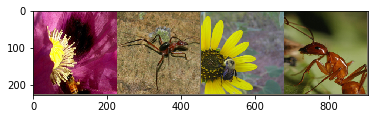

In [33]:
def image_show(inputs, title=None):
    """
    展示图像
    """
    inputs = inputs.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inputs = std * inputs + mean # 归一化
    inputs = np.clip(inputs,0,1) # 将inputs数组值限制在[0,1]之间
    plt.imshow(inputs)
    
    if title is not None:
        plt.titl(title)
    plt.pause(0.001) # 等待一会用于展示图更新
    
# 获取一批数据
inputs, classes = next(iter(dataloaders['train']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

# 显示图片
image_show(out)

### 训练模型
编写一个通用函数来训练模型。下面将说明：**调整学习速率**以此保证最好的模型。  

下面参数scheduler是一个来自torch.optim.lr_scheduler的学习速率调整类的对象(LR scheduler object)。

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepycopy(model,state_dict())
    
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print('Epoch {1}/{2}'.format(epoch,epochs-1))
        print('-'*10)
        
        # 训练和验证每个epoch，计算该epoch下的准确值
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train() # 设置模型为训练模式
            else:
                model.eval() # 设置为评估模式
            
            losses = 0.0
            num_correct = 0 # 预测正确的个数
            for inputs, labels in dataloaders[phase]:
                print(inputs,labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 优化器初始参数设置为0
                optimizer.zero_grad()
                
                # 向前传播
                # 为train时开启track，val关闭track
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # 得到最大概率的预测值
                    _, prediction = torch.max(outputs,1)
                    
                    # 计算损失值
                    loss = criterion(outputs, labels)
                    
                    # 反向传播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # 统计
                losses += loss.item() * inputs.size(0)
                num_correct += torch.sum(phase == labels.data)
            
            epoch_loss = losses / dataset_sizes[phase]
            epoch_accuarcy = corrects.double() / dataset_sizes[phase]
            
            print('{phase} Loss: {loss.4f} Avvuarcy : {acc.4f}'.format(phase=phase,
                                                                       loss=epoch_loss,acc=epoch_accuarcy
                                                                      ))
            # 深度复制模型
            if phase == 'val' and epoch_accuarcy > best_accuracy:
                best_accuracy = epoch_accuarcy
                best_model_wts = copy.deepycopy(model)
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {time.0f}m {second.0f}s'.format(time=time_elapsed // 60, time_elapsed % 60))
    print('Best val Accuracy : {acc.4f}'.format(acc = best_accuracy))
    
    # 返回最佳模型
    model.load_state_dict(best_model_wts)
    return model


### 可视化模型的预测结果

In [37]:
# 一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # 评估过程
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, prediction = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2,2,images_so_far)
                ax.axis('objectff')
                ax.set_title('prediction : {name}'.format(class_name[prediction[j]]))
                image_show(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    modelel.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 场景1：微调ConvNet
加载预训练模型并重置最终完全连接的图层。

In [39]:
model_ft = models.resnet18(pretrained=True) # 加载预先训练的模型
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2) # 将预训练的模型最后的全连接改为一个线性层，只输出两个值

model_ft = model_ft.to(device)

# 设置损失值计算函数
criterion = nn.CrossEntropyLoss()

# 设置优化器，使用随机梯度下降
optimizer = optim.SGD(model_ft.parameters(),lr=1e-3,momentum=0.9)

# 每7个epochs衰减LR，通过设置gamma=0.1
exp_lr_scheduler = lr_schedulerr.StepLR(optimizer,step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/zhangsong/.cache/torch/checkpoints/resnet18-5c106cde.pth
 18%|█▊        | 7.87M/44.7M [03:48<17:46, 36.2kB/s]  


KeyboardInterrupt: 

#### 训练和评估模型
（1）训练模型  
该过程在CPU上需要大约15-25分钟，但是在GPU上，它只需要不到一分钟。

In [ ]:
model = train_model(model, crierin, optimizer, exp_lr_scheduler, epochs=25)

(2) 模型评估效果可视化

In [ ]:
visualize_model(model)

### 场景2： ConvNet作为固定特征提取器
在这里需要冻结除最后一层之外的所有网络。通过设置requires_grad=Fals来冻结参数，这样在反向传播backward（）的时候他们的梯度不会被计算。

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
# 设置参数requires_grad=False
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2) # 最后全连接变为特定线性层

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 创建优化器，只对最后一层特定的线性层进行参数优化
optimizer = optim.SGD(model_conv.fc.parameters(), lr=1e-3, momentum=0.9)

# epoch每过7个以0.9的速率衰减学习速率
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


#### 训练和评估
（1）训练模型  
在CPU上，与前一个场景相比，这将花费大约一半的时间，因为不需要为太多的网络层计算参数梯度，但需要计算转发。

In [ ]:
model = tran_model(model, criterion, optimizer, exp_lr_scheduler, epochs=25)

（2）模型评估效果可视化

In [ ]:
visualize_model(model)

plt.ioff()
plt.show()